In [1123]:
%%capture
!pip install pycountry

In [1124]:
import pandas as pd
import numpy as np
import pycountry
import os, sys
parent_dir = os.path.abspath('../../')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [1125]:
time_periods = [2008, 2012, 2016, 2020]

In [1126]:
def convert_iso3_to_iso2(iso3_code):
    country = pycountry.countries.get(alpha_3=iso3_code)
    return country.alpha_2 if country else None

def convert_name_to_iso2(country_name):
    if country_name == 'Türkiye' or country_name == 'Turkiye' or country_name == 'Turkey':
        return "TR"
    if country_name == 'Republic of Moldova':
        return "MD"
    country = pycountry.countries.get(name=country_name)
    return country.alpha_2 if country else None

In [1127]:
population_100k = pd.read_csv('../../data/demographic/population_100k.csv')
population_100k_with_codes = population_100k.copy()
population_100k_with_codes = population_100k_with_codes[population_100k_with_codes['Country.Code'].notna()]
population_100k_with_codes['geo'] = population_100k_with_codes['Country.Code'].apply(convert_iso3_to_iso2)
population_100k_with_codes.rename(columns={'Year': 'TIME_PERIOD'}, inplace=True)
population = population_100k_with_codes.copy()
population['population'] = population_100k_with_codes['pop100k'] * 100000

Sanity check for population, e.g Austria

In [1128]:
population[population['Country.Code'] == 'AUT']

,Unnamed: 0,Country.Code,Country.Name,population,TIME_PERIOD,pop100k,geo
13608,13608,AUT,Austria,6937809.0,1950,69.37809,AT
13609,13609,AUT,Austria,6935070.0,1951,69.35070,AT
13610,13610,AUT,Austria,6925793.0,1952,69.25793,AT
13611,13611,AUT,Austria,6928236.0,1953,69.28236,AT
13612,13612,AUT,Austria,6935352.0,1954,69.35352,AT
...,...,...,...,...,...,...,...
13675,13675,AUT,Austria,8772740.0,2017,87.72740,AT
13676,13676,AUT,Austria,8822252.0,2018,88.22252,AT
13677,13677,AUT,Austria,8858773.0,2019,88.58773,AT
13678,13678,AUT,Austria,8901106.0,2020,89.01106,AT


## Load and prepare the data

Custom spreadsheet based on the [Activity classification](https://foundationaleconomy.com/activity-classification/) from the Foundational Economy Collective. In industry groups with different foundational types, we use the foundational type with the highest percentage, or if the shares are equal we pick the first "most important" in order of Material - Providential - Overlooked - Other.

In [1129]:
foundational_percentages = pd.read_csv('../../data/labor/foundational_percentages.csv')

Note the special cases below that were re-assigned manually. E.g. housing construction is Overlooked, not Other!

In [1130]:
foundational_percentages[foundational_percentages['nace_r2' ] == 'F41']

,nace_r2,Unnamed: 1,Material,Other,Overlooked,Providential,final_foundational
38,F41,NaN,NaN,50.00%,50.00%,NaN,Overlooked


Energy use data from IEA (World Indicators), 

TFC - Total Final Consumption

TES - Total Energy Supply

TFCPOP - TFC per capita

TESPOP - TES per capita

In [1131]:
energy_use_iea_csv = pd.read_csv('../../data/biophysical/iea_indicators.csv')
energy_use_iea_tfc = energy_use_iea_csv[energy_use_iea_csv['FLOW'] == 'TFC'].copy()
energy_use_iea_tfcpop = energy_use_iea_csv[energy_use_iea_csv['FLOW'] == 'TFCPOP'].copy()
energy_use_iea_tes = energy_use_iea_csv[energy_use_iea_csv['FLOW'] == 'TES'].copy()
energy_use_iea_tespop = energy_use_iea_csv[energy_use_iea_csv['FLOW'] == 'TESPOP'].copy()

In [1132]:
energy_use_iea_tfc['geo'] = energy_use_iea_tfc['COUNTRY'].apply(convert_iso3_to_iso2)
energy_use_iea_tfc.rename(columns={'TIME': 'TIME_PERIOD', 'Value': 'energy'}, inplace=True)
energy_use_iea_tfc_with_mypop = energy_use_iea_tfc.merge(population, on=['geo', 'TIME_PERIOD'], how='left')
energy_use_iea_tfc_with_mypop.drop(columns=['Unnamed: 0', 'Country.Code', 'Country.Name'], inplace=True)
energy_use_iea_tfc_mypop = energy_use_iea_tfc_with_mypop.copy()
energy_use_iea_tfc_mypop['energy_per_cap_GJ'] = energy_use_iea_tfc_with_mypop['energy'] / energy_use_iea_tfc_with_mypop['population'] * 1000000 * 41.868

In [1133]:
energy_use_iea_tes['geo'] = energy_use_iea_tes['COUNTRY'].apply(convert_iso3_to_iso2)
energy_use_iea_tes.rename(columns={'TIME': 'TIME_PERIOD', 'Value': 'energy'}, inplace=True)
energy_use_iea_tes_with_mypop = energy_use_iea_tes.merge(population, on=['geo', 'TIME_PERIOD'], how='left')
energy_use_iea_tes_with_mypop.drop(columns=['Unnamed: 0', 'Country.Code', 'Country.Name'], inplace=True)
energy_use_iea_tes_mypop = energy_use_iea_tes_with_mypop.copy()
energy_use_iea_tes_mypop['energy_per_cap_GJ'] = energy_use_iea_tes_with_mypop['energy'] / energy_use_iea_tes_with_mypop['population'] * 1000000 * 41.868

In [1134]:
energy_use_iea_tfc_mypop[(energy_use_iea_tfc_mypop['COUNTRY'] == 'AUT') & (energy_use_iea_tfc_mypop['TIME_PERIOD'].isin([2019, 2020, 2021]))]

,COUNTRY,Country,FLOW,Flow,TIME_PERIOD,Time,energy,Flag Codes,Flags,geo,population,pop100k,energy_per_cap_GJ
1571,AUT,Austria,TFC,Total final consumption (TFC) (Mtoe),2019,2019,28.029,NaN,NaN,AT,8858773.0,88.58773,132.469606
1572,AUT,Austria,TFC,Total final consumption (TFC) (Mtoe),2020,2020,26.558,NaN,NaN,AT,8901106.0,89.01106,124.920470
1573,AUT,Austria,TFC,Total final consumption (TFC) (Mtoe),2021,2021,28.101,NaN,NaN,AT,8914448.0,89.14448,131.980429


In [1135]:
energy_use_iea_tes_mypop[(energy_use_iea_tes_mypop['geo'] == 'AT') & (energy_use_iea_tes_mypop['TIME_PERIOD'].isin([2019, 2020, 2021]))]

,COUNTRY,Country,FLOW,Flow,TIME_PERIOD,Time,energy,Flag Codes,Flags,geo,population,pop100k,energy_per_cap_GJ
1004,AUT,Austria,TES,Total energy supply (TES) (Mtoe),2019,2019,33.442,NaN,NaN,AT,8858773.0,88.58773,158.052323
1005,AUT,Austria,TES,Total energy supply (TES) (Mtoe),2020,2020,31.622,NaN,NaN,AT,8901106.0,89.01106,148.739931
1006,AUT,Austria,TES,Total energy supply (TES) (Mtoe),2021,2021,33.293,NaN,NaN,AT,8914448.0,89.14448,156.365411


Looks good/comparable!

Energy use data from Exiobase, primary energy, consumption-based

This is in TJ, so need to convert

In [1136]:
energy_use_exiobase_csv = pd.read_csv('../../data/biophysical/exiobase_energy.csv')
energy_use_exiobase_with_mypop = energy_use_exiobase_csv.merge(population, on=['geo', 'TIME_PERIOD'], how='left')
energy_use_exiobase_with_mypop.drop(columns=['Unnamed: 0', 'Country.Code', 'Country.Name'], inplace=True)
energy_use_exiobase_mypop = energy_use_exiobase_with_mypop.copy()
energy_use_exiobase_mypop['energy_per_cap_GJ'] = energy_use_exiobase_with_mypop['energy'] / energy_use_exiobase_with_mypop['population'] * 1000

In [1137]:
energy_use_exiobase_mypop[(energy_use_exiobase_mypop['geo'] == 'AT') & (energy_use_exiobase_mypop['TIME_PERIOD'].isin([2019, 2020, 2021]))]

,TIME_PERIOD,geo,energy,population,pop100k,energy_per_cap_GJ
1176,2019,AT,1410000.0,8858773.0,88.58773,159.164254
1225,2020,AT,1490000.0,8901106.0,89.01106,167.394928
1274,2021,AT,1440000.0,8914448.0,89.14448,161.535521


## EXIOBASE Energy Data

Calculate Consumption-Based Final Energy from territorial and consumption-based primary

In [1138]:
energy_use_to_merge = pd.merge(energy_use_iea_tfc_mypop, energy_use_iea_tes_mypop, on=['geo', 'TIME_PERIOD'], how='left', suffixes=('_iea_final', '_iea_production'))
energy_use_merged = pd.merge(energy_use_exiobase_mypop, energy_use_to_merge, on=['geo', 'TIME_PERIOD'], how='left')
energy_use_merged.rename(columns={'energy_per_cap_GJ': 'energy_per_cap_GJ_exiobase_production'}, inplace=True)

In [1139]:
# FinalConsumptionBased = (PrimaryConsumptionBased / PrimaryTerritorial) * FinalTerritorial
# Handle division by zero by using np.where to avoid dividing by zero
energy_use_merged['energy_per_cap_GJ_exiobase_final'] = np.where(energy_use_merged['energy_per_cap_GJ_iea_production'] != 0,
                                     (energy_use_merged['energy_per_cap_GJ_exiobase_production'] / energy_use_merged['energy_per_cap_GJ_iea_production']) * energy_use_merged['energy_per_cap_GJ_iea_final'],
                                     np.nan)
energy_use_merged = energy_use_merged[['geo', 'TIME_PERIOD', 'energy_per_cap_GJ_exiobase_production', 'energy_per_cap_GJ_exiobase_final', 'energy_per_cap_GJ_iea_production', 'energy_per_cap_GJ_iea_final']]

In [1140]:
energy_use_merged[(energy_use_merged['geo'] == 'AT') & (energy_use_merged['TIME_PERIOD'].isin([2019, 2020, 2021]))]

,geo,TIME_PERIOD,energy_per_cap_GJ_exiobase_production,energy_per_cap_GJ_exiobase_final,energy_per_cap_GJ_iea_production,energy_per_cap_GJ_iea_final
1176,AT,2019,159.164254,133.401558,158.052323,132.469606
1225,AT,2020,167.394928,140.588024,148.739931,124.920470
1274,AT,2021,161.535521,136.344267,156.365411,131.980429


In [1141]:
energy_use_iea = energy_use_merged[['geo', 'TIME_PERIOD', 'energy_per_cap_GJ_iea_final']]
energy_use_iea.rename(columns={'energy_per_cap_GJ_iea_final': 'energy'}, inplace=True)

/var/folders/6l/9wnlb_cx2h382r0y3jq99h5h0000gn/T/ipykernel_51944/2247329839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_use_iea.rename(columns={'energy_per_cap_GJ_iea_final': 'energy'}, inplace=True)


In [1142]:
energy_use_exiobase = energy_use_merged[['geo', 'TIME_PERIOD', 'energy_per_cap_GJ_exiobase_final']]
energy_use_exiobase.rename(columns={'energy_per_cap_GJ_exiobase_final': 'energy'}, inplace=True)

/var/folders/6l/9wnlb_cx2h382r0y3jq99h5h0000gn/T/ipykernel_51944/1729903428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_use_exiobase.rename(columns={'energy_per_cap_GJ_exiobase_final': 'energy'}, inplace=True)


Employment and hours worked data from the [EU labour costs survey](https://ec.europa.eu/eurostat/databrowser/view/lc_rnum1_r2/default/table?lang=en), collected every 4 years

In [1143]:
labour_cost_survey_data = pd.read_csv('../../data/labor/lc_nnum1_r2_linear.csv')

Employment and hours worked data from [National accounts](https://ec.europa.eu/eurostat/databrowser/view/nama_10_a64_e/default/table?lang=en), collected annually. Run the same regressions with this and the previous variable to see which one is best suited for the quantitative analysis.

In [1144]:
labour_accounts_data = pd.read_csv('../../data/labor/nama_10_a64_e_linear.csv')

Need satisfaction variables from World Development Indicators (School enrollment) and World Happiness Report (Life expectancy, Life satisfaction, etc.)

In [1145]:
from functions.create_panel_dataset import clean_and_transform_wdi_outcomes

In [1146]:
whr = pd.read_csv('../../data/need_satisfaction/whr.csv')
school_enrollment = pd.read_csv('../../data/need_satisfaction/wdi_schoolenr.csv')
undp_composite = pd.read_csv('../../data/need_satisfaction/undp_composite.csv')
lifeexpectancy = pd.read_csv('../../data/need_satisfaction/wdi_lifeexpectancy.csv')
communicable = pd.read_csv('../../data/need_satisfaction/morewdioutcomes/communicabledisease/communicable.csv')
hospitalbeds = pd.read_csv('../../data/need_satisfaction/morewdioutcomes/hospitalbeds/hospitalbeds.csv')
infantmortality = pd.read_csv('../../data/need_satisfaction/morewdioutcomes/infantmortality/infantmortality.csv')
pollution = pd.read_csv('../../data/need_satisfaction/morewdioutcomes/pollution/pollution.csv')
railpassengers = pd.read_csv('../../data/need_satisfaction/morewdioutcomes/railpassengers/railpassengers.csv')
roadinjury = pd.read_csv('../../data/need_satisfaction/morewdioutcomes/roadinjury/roadinjury.csv')
suicide = pd.read_csv('../../data/need_satisfaction/morewdioutcomes/suicide/suicide.csv')

In [1147]:
accountsall = pd.read_csv('../../data/need_satisfaction/0303/accountsall/accountsall.csv')
accountspoorest = pd.read_csv('../../data/need_satisfaction/0303/accountspoorest/accountspoorest.csv')
broadband = pd.read_csv('../../data/need_satisfaction/0303/broadband/broadband.csv')
foodinsecurity = pd.read_csv('../../data/need_satisfaction/0303/foodinsecurity/foodinsecurity.csv')
homicides = pd.read_csv('../../data/need_satisfaction/0303/homicides/homicides.csv')
immunization = pd.read_csv('../../data/need_satisfaction/0303/immunization/immunization.csv')
internet = pd.read_csv('../../data/need_satisfaction/0303/internet/internet.csv')
povertymulti = pd.read_csv('../../data/need_satisfaction/0303/povertymulti/povertymulti.csv')
povertynational = pd.read_csv('../../data/need_satisfaction/0303/povertynational/povertynational.csv')
renewable = pd.read_csv('../../data/need_satisfaction/0303/renewable/renewable.csv')
safesanitation = pd.read_csv('../../data/need_satisfaction/0303/safesanitation/safesanitation.csv')
telephone = pd.read_csv('../../data/need_satisfaction/0303/telephone/telephone.csv')
theft = pd.read_csv('../../data/need_satisfaction/0303/theft/theft.csv')
uppersecondary = pd.read_csv('../../data/need_satisfaction/0303/uppersecondary/uppersecondary.csv')

In [1148]:
accountsall_cleaned = clean_and_transform_wdi_outcomes(accountsall, 'accountsall')
accountspoorest_cleaned = clean_and_transform_wdi_outcomes(accountspoorest, 'accountspoorest')
broadband_cleaned = clean_and_transform_wdi_outcomes(broadband, 'broadband')
foodinsecurity_cleaned = clean_and_transform_wdi_outcomes(foodinsecurity, 'foodinsecurity')
homicides_cleaned = clean_and_transform_wdi_outcomes(homicides, 'homicides')
immunization_cleaned = clean_and_transform_wdi_outcomes(immunization, 'immunization')
internet_cleaned = clean_and_transform_wdi_outcomes(internet, 'internet')
povertymulti_cleaned = clean_and_transform_wdi_outcomes(povertymulti, 'povertymulti')
povertynational_cleaned = clean_and_transform_wdi_outcomes(povertynational, 'povertynational')
renewable_cleaned = clean_and_transform_wdi_outcomes(renewable, 'renewable')
safesanitation_cleaned = clean_and_transform_wdi_outcomes(safesanitation, 'safesanitation')
telephone_cleaned = clean_and_transform_wdi_outcomes(telephone, 'telephone')
# theft_cleaned = clean_and_transform_wdi_outcomes(theft, 'theft')uppersecondary_cleaned = clean_and_transform_wdi_outcomes(uppersecondary, 'uppersecondary')

In [1149]:
def copy_year_values(df, column_name, year_mapping, year_column='Year', country_column='Country.Code'):
    shifted_df = df.copy()
    shifted_df[year_column] = shifted_df[year_column].astype(int)
    unique_countries = shifted_df[country_column].unique()
    
    rows_to_add = []  # List to hold new rows to be appended
    
    for country in unique_countries:
        for source_year, target_years in year_mapping.items():
            if not isinstance(target_years, list):
                target_years = [target_years]
            
            value_for_source_year = shifted_df.loc[(shifted_df[country_column] == country) & (shifted_df[year_column] == source_year), column_name].values
            for target_year in target_years:
                if shifted_df.loc[(shifted_df[country_column] == country) & (shifted_df[year_column] == target_year)].empty:
                    # If target year row doesn't exist, prepare a new row to be added
                    if len(value_for_source_year) > 0:
                        new_row_value = value_for_source_year[0]
                    else:
                        new_row_value = np.nan
                    new_row = pd.DataFrame([[country, target_year, new_row_value]], columns=[country_column, year_column, column_name])
                    rows_to_add.append(new_row)
                elif len(value_for_source_year) > 0:
                    # If target year row exists, just update the value
                    shifted_df.loc[(shifted_df[country_column] == country) & (shifted_df[year_column] == target_year), column_name] = value_for_source_year[0]
    
    # Append all new rows at once for efficiency
    if rows_to_add:
        shifted_df = pd.concat([shifted_df] + rows_to_add, ignore_index=True)
    
    return shifted_df



In [1150]:
foodinsecurity_cleaned_shift = copy_year_values(foodinsecurity_cleaned, 'foodinsecurity', {2012: 2015})
uppersecondary_cleaned_shift = copy_year_values(uppersecondary_cleaned, 'uppersecondary', {2020: 2019})
accountsall_cleaned_shift = copy_year_values(accountsall_cleaned, 'accountsall', {2012: 2011, 2016: 2017, 2020: 2021})
accountspoorest_cleaned_shift = copy_year_values(accountspoorest_cleaned, 'accountspoorest', {2012: 2011, 2016: 2017, 2020: 2021})

In [1151]:
accountsall_cleaned[accountsall_cleaned['Country.Code'] == 'AUT']

,Year,Country.Code,Country.Name,accountsall
11,2003,AUT,Austria,NaN
233,2004,AUT,Austria,NaN
455,2005,AUT,Austria,NaN
677,2006,AUT,Austria,NaN
899,2007,AUT,Austria,NaN
1121,2008,AUT,Austria,NaN
1343,2009,AUT,Austria,NaN
1565,2010,AUT,Austria,NaN
1787,2011,AUT,Austria,97.08
2009,2012,AUT,Austria,NaN


In [1152]:
# there are three rows for each year, take the average
immunization_cleaned_avg = immunization_cleaned.groupby(['Country.Name', 'Country.Code', 'Year']).mean().reset_index()

In [1153]:
tests = pd.read_csv('../../data/need_satisfaction/0303/tests_hci/tests.csv')

In [1154]:
# Assuming tests_cleaned is your original DataFrame and it's already defined
tests_cleaned_shifted = tests_cleaned.copy()
tests_cleaned_shifted['Year'] = tests_cleaned_shifted['Year'].astype(int)
unique_countries = tests_cleaned_shifted['Country.Code'].unique()

for country in unique_countries:
    for source_year, target_years in {2010: 2012, 2017: 2016}.items():
        if not isinstance(target_years, list):
            target_years = [target_years]
        
        # Corrected to check 'Year' == source_year
        value_for_source_year = tests_cleaned_shifted.loc[(tests_cleaned_shifted['Country.Code'] == country) & (tests_cleaned_shifted['Year'] == source_year), 'tests'].values
        
        if len(value_for_source_year) > 0:
            for target_year in target_years:
                # Direct assignment without unnecessary type conversion
                tests_cleaned_shifted.loc[(tests_cleaned_shifted['Country.Code'] == country) & (tests_cleaned_shifted['Year'] == target_year), 'tests'] = value_for_source_year[0]


In [1155]:
tests_cleaned_shifted[tests_cleaned_shifted['Country.Code'] == 'AUT']

,Year,Country.Code,Country.Name,tests
11,2010,AUT,Austria,503.468140
233,2011,AUT,Austria,NaN
455,2012,AUT,Austria,503.468140
677,2013,AUT,Austria,NaN
899,2014,AUT,Austria,NaN
1121,2015,AUT,Austria,NaN
1343,2016,AUT,Austria,525.000000
1565,2017,AUT,Austria,525.000000
1787,2018,AUT,Austria,524.832642
2009,2019,AUT,Austria,NaN


In [1156]:
dietaryrisks = pd.read_csv('../../data/need_satisfaction/0303/dietaryrisks_gbd/dietaryrisks.csv')
nutrideficiencies = pd.read_csv('../../data/need_satisfaction/0303/nutrideficiencies_gbd/nutrideficiencies.csv')
unsafewater = pd.read_csv('../../data/need_satisfaction/0303/unsafewater_gbd/unsafewater.csv')

In [1157]:
# use convert_name_to_iso2 to convert country names to iso2 codes
dietaryrisks_cleaned = dietaryrisks.copy()
dietaryrisks_cleaned['geo'] = dietaryrisks_cleaned['location_name'].apply(convert_name_to_iso2)
# drop all except geo, year, val and rename to geo, TIME_PERIOD, dietaryrisks
dietaryrisks_cleaned = dietaryrisks_cleaned[['geo', 'year', 'val']]
dietaryrisks_cleaned.rename(columns={'year': 'TIME_PERIOD', 'val': 'dietaryrisks'}, inplace=True)
# only keep where geo is not None
dietaryrisks_cleaned = dietaryrisks_cleaned[dietaryrisks_cleaned['geo'].notna()]
# copy 2020 data to 2019
dietaryrisks_cleaned_shift = copy_year_values(dietaryrisks_cleaned, 'dietaryrisks', {2019: 2020}, year_column='TIME_PERIOD', country_column='geo')

In [1158]:
nutrideficiencies_cleaned = nutrideficiencies.copy()
nutrideficiencies_cleaned['geo'] = nutrideficiencies_cleaned['location_name'].apply(convert_name_to_iso2)
nutrideficiencies_cleaned = nutrideficiencies_cleaned[['geo', 'year', 'val']]
nutrideficiencies_cleaned.rename(columns={'year': 'TIME_PERIOD', 'val': 'nutrideficiencies'}, inplace=True)
nutrideficiencies_cleaned = nutrideficiencies_cleaned[nutrideficiencies_cleaned['geo'].notna()]
nutrideficiencies_cleaned_shift = nutrideficiencies_cleaned.copy()
# copy 2020 data to 2019
nutrideficiencies_cleaned_shift = copy_year_values(nutrideficiencies_cleaned_shift, 'nutrideficiencies', {2020: 2019}, year_column='TIME_PERIOD', country_column='geo')

In [1159]:
nutrideficiencies_cleaned_shift[nutrideficiencies_cleaned_shift['geo'] == 'AT']

,geo,TIME_PERIOD,nutrideficiencies
1530,AT,1990,0.059356
1531,AT,1991,0.058425
1532,AT,1992,0.057514
1533,AT,1993,0.056662
1534,AT,1994,0.055869
1535,AT,1995,0.055147
1536,AT,1996,0.054442
1537,AT,1997,0.053701
1538,AT,1998,0.052980
1539,AT,1999,0.052264


In [1160]:
unsafewater_cleaned = unsafewater.copy()
unsafewater_cleaned['geo'] = unsafewater_cleaned['location_name'].apply(convert_name_to_iso2)
unsafewater_cleaned = unsafewater_cleaned[['geo', 'year', 'val']]
unsafewater_cleaned.rename(columns={'year': 'TIME_PERIOD', 'val': 'unsafewater'}, inplace=True)
unsafewater_cleaned = unsafewater_cleaned[unsafewater_cleaned['geo'].notna()]
unsafewater_cleaned_shift = unsafewater_cleaned.copy()
# copy 2020 data to 2019
unsafewater_cleaned_shift = copy_year_values(unsafewater_cleaned_shift, 'unsafewater', {2019: 2020}, year_column='TIME_PERIOD', country_column='geo')

In [1161]:
healthessential = pd.read_csv('../../data/need_satisfaction/0303/healthessential.csv')

In [1162]:
healthessential_cleaned = healthessential.copy()
healthessential_cleaned['geo'] = healthessential_cleaned['GeoAreaName'].apply(convert_name_to_iso2)
healthessential_cleaned = healthessential_cleaned[['geo', 'TimePeriod', 'Value']]
healthessential_cleaned.rename(columns={'TimePeriod': 'TIME_PERIOD', 'Value': 'healthessential'}, inplace=True)
healthessential_cleaned = healthessential_cleaned[healthessential_cleaned['geo'].notna()]
# shift 2010 data to 2012 and 2015 data to 2016 and 2019 data to 2020
healthessential_cleaned_shift = copy_year_values(healthessential_cleaned, 'healthessential', {2012: 2010, 2016: 2015, 2020: 2019}, year_column='TIME_PERIOD', country_column='geo')

In [1163]:
housing = pd.read_csv('../../data/need_satisfaction/moreeurostat/housing.csv')

In [1164]:
housing_clean = housing.rename(columns={'OBS_VALUE': 'housing'})
housing_clean = housing_clean.drop(['DATAFLOW', 'LAST UPDATE', 'freq', 'unit', 'incgrp', 'hhtyp', 'n_item','OBS_FLAG'], axis=1)

In [1165]:
housing_clean['TIME_PERIOD'].unique()

array([2017, 2018, 2019, 2020, 2011, 2012, 2013, 2014, 2015, 2016, 2023,
       2021])

In [1166]:
whr_with_codes = whr.copy()
whr_with_codes['geo'] = whr['Country name'].apply(convert_name_to_iso2)
whr_with_codes = whr_with_codes[whr_with_codes['geo'].notna()]
whr_with_codes.rename(columns={'year': 'TIME_PERIOD', 'Life Ladder': 'ladder', 'Social support': 'socialsupport', 'Healthy life expectancy at birth': 'hale', 'Freedom to make life choices': 'freedom', 'Generosity': 'charity', 'Perceptions of corruption': 'corruption', 'Positive affect': 'positive', 'Negative affect': 'negative'}, inplace=True)
whr_with_codes.drop(columns=['Country name', 'Log GDP per capita'], inplace=True)

In [1167]:
undp_education = undp_composite.copy()
undp_education['geo'] = undp_education['ISO3'].apply(convert_iso3_to_iso2)
undp_education = undp_education[undp_education['geo'].notna()]
undp_education.rename(columns={'Year': 'TIME_PERIOD', 'Expected Years of Schooling': 'education'}, inplace=True)
undp_education = undp_education[undp_education['Gender'] == 'Total']
undp_education.drop(columns=['ISO3', 'Country', 'Region', 'Gender', 'Human Development Index', 'Life Expectancy at Birth', 'Mean Years of Schooling', 'Gross National Income Per Capita'], inplace=True)

In [1168]:
# shift observations one Year forward to match with the rest of the data
communicable_cleaned_shift = communicable_cleaned.copy()
communicable_cleaned_shift['Year'] = communicable_cleaned_shift['Year'] + 1
# shift year 2011 to 2012
communicable_cleaned_shift = copy_year_values(communicable_cleaned_shift, 'communicable', {2012: 2011})

In [1169]:
school_enrollment_cleaned = clean_and_transform_wdi_outcomes(school_enrollment, 'schoolenr')
lifeexpectancy_cleaned = clean_and_transform_wdi_outcomes(lifeexpectancy, 'lifeexpectancy')
communicable_cleaned = clean_and_transform_wdi_outcomes(communicable, 'communicable')
hospitalbeds_cleaned = clean_and_transform_wdi_outcomes(hospitalbeds, 'hospitalbeds')
infantmortality_cleaned = clean_and_transform_wdi_outcomes(infantmortality, 'infantmortality')
pollution_cleaned = clean_and_transform_wdi_outcomes(pollution, 'pollution')
railpassengers_cleaned = clean_and_transform_wdi_outcomes(railpassengers, 'railpassengers')
roadinjury_cleaned = clean_and_transform_wdi_outcomes(roadinjury, 'roadinjury')
suicide_cleaned = clean_and_transform_wdi_outcomes(suicide, 'suicide')

In [1170]:
wdi_need_satisfaction = school_enrollment_cleaned.merge(lifeexpectancy_cleaned, on=['Year', 'Country.Code', 'Country.Name'], how='left')
wdi_need_satisfaction = wdi_need_satisfaction.merge(communicable_cleaned_shift, on=['Year', 'Country.Code', 'Country.Name'], how='left')
wdi_need_satisfaction = wdi_need_satisfaction.merge(hospitalbeds_cleaned, on=['Year', 'Country.Code', 'Country.Name'], how='left')
wdi_need_satisfaction = wdi_need_satisfaction.merge(infantmortality_cleaned, on=['Year', 'Country.Code', 'Country.Name'], how='left')
# wdi_need_satisfaction = wdi_need_satisfaction.merge(pollution_cleaned, on=['Year', 'Country.Code', 'Country.Name'], how='left')
wdi_need_satisfaction = wdi_need_satisfaction.merge(railpassengers_cleaned, on=['Year', 'Country.Code', 'Country.Name'], how='left')
wdi_need_satisfaction = wdi_need_satisfaction.merge(roadinjury_cleaned, on=['Year', 'Country.Code', 'Country.Name'], how='left')
wdi_need_satisfaction = wdi_need_satisfaction.merge(suicide_cleaned, on=['Year', 'Country.Code', 'Country.Name'], how='left')
wdi_need_satisfaction = wdi_need_satisfaction.merge(accountsall_cleaned_shift, on=['Year', 'Country.Code', 'Country.Name'], how='left')
wdi_need_satisfaction = wdi_need_satisfaction.merge(accountspoorest_cleaned_shift, on=['Year', 'Country.Code', 'Country.Name'], how='left')
wdi_need_satisfaction = wdi_need_satisfaction.merge(broadband_cleaned, on=['Year', 'Country.Code', 'Country.Name'], how='left')
wdi_need_satisfaction = wdi_need_satisfaction.merge(foodinsecurity_cleaned_shift, on=['Year', 'Country.Code', 'Country.Name'], how='left')
wdi_need_satisfaction = wdi_need_satisfaction.merge(homicides_cleaned, on=['Year', 'Country.Code', 'Country.Name'], how='left')
wdi_need_satisfaction = wdi_need_satisfaction.merge(immunization_cleaned_avg, on=['Year', 'Country.Code', 'Country.Name'], how='left')
wdi_need_satisfaction = wdi_need_satisfaction.merge(internet_cleaned, on=['Year', 'Country.Code', 'Country.Name'], how='left')
wdi_need_satisfaction = wdi_need_satisfaction.merge(povertymulti_cleaned, on=['Year', 'Country.Code', 'Country.Name'], how='left')
wdi_need_satisfaction = wdi_need_satisfaction.merge(povertynational_cleaned, on=['Year', 'Country.Code', 'Country.Name'], how='left')
wdi_need_satisfaction = wdi_need_satisfaction.merge(renewable_cleaned, on=['Year', 'Country.Code', 'Country.Name'], how='left')
wdi_need_satisfaction = wdi_need_satisfaction.merge(safesanitation_cleaned, on=['Year', 'Country.Code', 'Country.Name'], how='left')
wdi_need_satisfaction = wdi_need_satisfaction.merge(telephone_cleaned, on=['Year', 'Country.Code', 'Country.Name'], how='left')
# wdi_need_satisfaction = wdi_need_satisfaction.merge(theft_cleaned, on=['Year', 'Country.Code', 'Country.Name'], how='left')
wdi_need_satisfaction = wdi_need_satisfaction.merge(uppersecondary_cleaned_shift, on=['Year', 'Country.Code', 'Country.Name'], how='left')
wdi_need_satisfaction = wdi_need_satisfaction.merge(tests_cleaned_shift, on=['Year', 'Country.Code', 'Country.Name'], how='left')
wdi_need_satisfaction['geo'] = wdi_need_satisfaction['Country.Code'].apply(convert_iso3_to_iso2)
wdi_need_satisfaction = wdi_need_satisfaction[wdi_need_satisfaction['geo'].notna()]
wdi_need_satisfaction.rename(columns={'Year': 'TIME_PERIOD', 'lifeexpectancy': 'wdi_hale'}, inplace=True)

In [1171]:
whr = pd.read_csv('../../data/need_satisfaction/whr.csv')
school_enrollment = pd.read_csv('../../data/need_satisfaction/wdi_schoolenr.csv')
undp_composite = pd.read_csv('../../data/need_satisfaction/undp_composite.csv')
lifeexpectancy = pd.read_csv('../../data/need_satisfaction/wdi_lifeexpectancy.csv')
communicable = pd.read_csv('../../data/need_satisfaction/morewdioutcomes/communicabledisease/communicable.csv')
hospitalbeds = pd.read_csv('../../data/need_satisfaction/morewdioutcomes/hospitalbeds/hospitalbeds.csv')
infantmortality = pd.read_csv('../../data/need_satisfaction/morewdioutcomes/infantmortality/infantmortality.csv')
pollution = pd.read_csv('../../data/need_satisfaction/morewdioutcomes/pollution/pollution.csv')
railpassengers = pd.read_csv('../../data/need_satisfaction/morewdioutcomes/railpassengers/railpassengers.csv')
roadinjury = pd.read_csv('../../data/need_satisfaction/morewdioutcomes/roadinjury/roadinjury.csv')
suicide = pd.read_csv('../../data/need_satisfaction/morewdioutcomes/suicide/suicide.csv')

In [1172]:
wdi_need_satisfaction_with_mypop = wdi_need_satisfaction.merge(population, on=['geo', 'TIME_PERIOD', 'Country.Code', 'Country.Name'], how='left')
wdi_need_satisfaction_with_mypop.drop(columns=['Unnamed: 0'], inplace=True)
wdi_need_satisfaction_mypop = wdi_need_satisfaction_with_mypop.copy()
wdi_need_satisfaction_mypop['rail'] = wdi_need_satisfaction_mypop['railpassengers'] / wdi_need_satisfaction_mypop['population'] * 100000
wdi_need_satisfaction_mypop.drop('population', axis=1)

,TIME_PERIOD,Country.Code,Country.Name,schoolenr,wdi_hale,communicable,hospitalbeds,infantmortality,railpassengers,roadinjury,...,povertymulti,povertynational,renewable,safesanitation,telephone,uppersecondary,tests,geo,pop100k,rail
0,1973,AFG,Afghanistan,11.57862,39.003,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AF,114.27350,NaN
1,1974,AFG,Afghanistan,11.73926,39.550,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AF,117.23259,NaN
2,1975,AFG,Afghanistan,12.25712,40.100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AF,120.16498,NaN
3,1976,AFG,Afghanistan,13.15846,40.645,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AF,122.98274,NaN
4,1977,AFG,Afghanistan,13.99915,41.228,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AF,125.52261,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10745,2018,ZWE,Zimbabwe,NaN,61.414,NaN,NaN,42.1,98.0,40.6,...,NaN,NaN,80.43,33.544266,1.786113,NaN,396.138824,ZW,149.00379,0.657701
10746,2019,ZWE,Zimbabwe,NaN,61.292,NaN,NaN,41.1,206.0,41.2,...,NaN,38.3,81.52,32.961481,1.730647,NaN,NaN,ZW,152.03989,1.354908
10747,2020,ZWE,Zimbabwe,NaN,61.124,47.647301,NaN,40.5,17.0,NaN,...,NaN,NaN,84.36,32.381232,1.608630,NaN,396.138824,ZW,155.05226,0.109640
10748,2021,ZWE,Zimbabwe,NaN,59.253,NaN,NaN,39.6,NaN,NaN,...,NaN,NaN,NaN,31.802437,1.521997,NaN,NaN,ZW,158.34106,NaN


In [1173]:
wdi_need_satisfaction_mypop

,TIME_PERIOD,Country.Code,Country.Name,schoolenr,wdi_hale,communicable,hospitalbeds,infantmortality,railpassengers,roadinjury,...,povertynational,renewable,safesanitation,telephone,uppersecondary,tests,geo,population,pop100k,rail
0,1973,AFG,Afghanistan,11.57862,39.003,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,AF,11427350.0,114.27350,NaN
1,1974,AFG,Afghanistan,11.73926,39.550,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,AF,11723259.0,117.23259,NaN
2,1975,AFG,Afghanistan,12.25712,40.100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,AF,12016498.0,120.16498,NaN
3,1976,AFG,Afghanistan,13.15846,40.645,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,AF,12298274.0,122.98274,NaN
4,1977,AFG,Afghanistan,13.99915,41.228,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,AF,12552261.0,125.52261,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10745,2018,ZWE,Zimbabwe,NaN,61.414,NaN,NaN,42.1,98.0,40.6,...,NaN,80.43,33.544266,1.786113,NaN,396.138824,ZW,14900379.0,149.00379,0.657701
10746,2019,ZWE,Zimbabwe,NaN,61.292,NaN,NaN,41.1,206.0,41.2,...,38.3,81.52,32.961481,1.730647,NaN,NaN,ZW,15203989.0,152.03989,1.354908
10747,2020,ZWE,Zimbabwe,NaN,61.124,47.647301,NaN,40.5,17.0,NaN,...,NaN,84.36,32.381232,1.608630,NaN,396.138824,ZW,15505226.0,155.05226,0.109640
10748,2021,ZWE,Zimbabwe,NaN,59.253,NaN,NaN,39.6,NaN,NaN,...,NaN,NaN,31.802437,1.521997,NaN,NaN,ZW,15834106.0,158.34106,NaN


In [1174]:
need_satisfaction = whr_with_codes.merge(wdi_need_satisfaction_mypop, on=['geo', 'TIME_PERIOD'], how='left')
need_satisfaction = need_satisfaction.merge(housing_clean, on=['geo', 'TIME_PERIOD'], how='left')
need_satisfaction = need_satisfaction.merge(undp_education, on=['geo', 'TIME_PERIOD'], how='left')
need_satisfaction = need_satisfaction.merge(dietaryrisks_cleaned_shift, on=['geo', 'TIME_PERIOD'], how='left')
need_satisfaction = need_satisfaction.merge(unsafewater_cleaned_shift, on=['geo', 'TIME_PERIOD'], how='left')
need_satisfaction = need_satisfaction.merge(nutrideficiencies_cleaned_shift, on=['geo', 'TIME_PERIOD'], how='left')
need_satisfaction = need_satisfaction.merge(healthessential_cleaned_shift, on=['geo', 'TIME_PERIOD'], how='left')
need_satisfaction.drop(columns=['Country.Code', 'Country.Name'], inplace=True)

In [1175]:
need_satisfaction

,TIME_PERIOD,ladder,socialsupport,hale,freedom,charity,corruption,positive,negative,geo,...,tests,population,pop100k,rail,housing,education,dietaryrisks,unsafewater,nutrideficiencies,healthessential
0,2008,3.724,0.451,50.500,0.718,0.168,0.882,0.414,0.258,AF,...,NaN,25886953.0,258.86953,NaN,NaN,8.460032,0.052138,0.073745,0.160037,NaN
1,2009,4.402,0.552,50.800,0.679,0.191,0.850,0.481,0.237,AF,...,NaN,26967445.0,269.67445,NaN,NaN,8.726570,0.053300,0.068107,0.157002,NaN
2,2010,4.758,0.539,51.100,0.600,0.121,0.707,0.517,0.275,AF,...,NaN,27803170.0,278.03170,NaN,NaN,9.002690,0.053908,0.064913,0.154186,29.0
3,2011,3.832,0.521,51.400,0.496,0.164,0.731,0.480,0.267,AF,...,NaN,28576174.0,285.76174,NaN,NaN,9.278810,0.054974,0.061501,0.151461,NaN
4,2012,3.783,0.521,51.700,0.531,0.238,0.776,0.614,0.268,AF,...,NaN,29922140.0,299.22140,NaN,NaN,9.577323,0.055635,0.057938,0.148643,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1948,2018,3.616,0.775,52.625,0.763,-0.051,0.844,0.658,0.212,ZW,...,396.138824,14900379.0,149.00379,0.657701,NaN,11.981767,0.032689,0.061943,0.200837,NaN
1949,2019,2.694,0.759,53.100,0.632,-0.047,0.831,0.658,0.235,ZW,...,NaN,15203989.0,152.03989,1.354908,NaN,12.110969,0.033730,0.060843,0.200347,55.0
1950,2020,3.160,0.717,53.575,0.643,0.006,0.789,0.661,0.346,ZW,...,396.138824,15505226.0,155.05226,0.109640,NaN,12.110969,0.033730,0.060843,NaN,NaN
1951,2021,3.155,0.685,54.050,0.668,-0.076,0.757,0.610,0.242,ZW,...,NaN,15834106.0,158.34106,NaN,NaN,12.110969,NaN,NaN,NaN,55.0


Finally, get the provisioning factors that were found significant in the original JV analysis.

In [1176]:
from functions.create_panel_dataset import clean_and_transform_wdi
goveffectiveness = pd.read_csv('../../data/wdi_goveffectiveness.csv')
gini = pd.read_csv('../../data/wdi_gini.csv')
goveffectiveness_cleaned = clean_and_transform_wdi(goveffectiveness, 'goveffectiveness')
gini_cleaned = clean_and_transform_wdi(gini, 'gini')
wdi_provisioning_factors = goveffectiveness_cleaned.merge(gini_cleaned, on=['Year', 'Country.Code', 'Country.Name'], how='left')
wdi_provisioning_factors['geo'] = wdi_provisioning_factors['Country.Code'].apply(convert_iso3_to_iso2)
wdi_provisioning_factors = wdi_provisioning_factors[wdi_provisioning_factors['geo'].notna()]
wdi_provisioning_factors.rename(columns={'Year': 'TIME_PERIOD'}, inplace=True)
wdi_provisioning_factors.drop(columns=['Country.Code', 'Country.Name'], inplace=True)

Count the number of unique countries that are available in both datasets.

In [1177]:
labour_cost_survey_geo = labour_cost_survey_data.geo.unique()
energy_geo = energy_use_iea.geo.unique()
energy_lc_sv_shared_geo = np.intersect1d(labour_cost_survey_geo, energy_geo)
energy_lc_sv_shared_geo = np.delete(energy_lc_sv_shared_geo, np.where(energy_lc_sv_shared_geo == 'EU27_2020'))
print(f'The labour cost survey + energy intersection has {len(energy_lc_sv_shared_geo)} unique countries')
labour_accounts_geo = labour_accounts_data.geo.unique()
energy_lc_ac_shared_geo = np.intersect1d(labour_accounts_geo, energy_geo)
energy_lc_ac_shared_geo = np.delete(energy_lc_ac_shared_geo, np.where(energy_lc_ac_shared_geo == 'EU27_2020'))
print(f'The labour accounts + energy intersection has {len(energy_lc_ac_shared_geo)} unique countries')
print(
    f'Countries that are in the labour cost survey variant but not in labour accounts are: {np.setdiff1d(energy_lc_sv_shared_geo, energy_lc_ac_shared_geo)}')

The labour cost survey + energy intersection has 29 unique countries
The labour accounts + energy intersection has 28 unique countries
Countries that are in the labour cost survey variant but not in labour accounts are: ['TR']


Add the foundational type (`final_foundational` column) from `foundational_percentages` to the labour data.

In [1178]:
foundational_percentages_selected = foundational_percentages[['nace_r2', 'final_foundational']]
labour_cost_survey_with_foundational = labour_cost_survey_data.merge(foundational_percentages_selected, on='nace_r2',
                                                                     how='left')
labour_accounts_with_foundational = labour_accounts_data.merge(foundational_percentages_selected, on='nace_r2',
                                                               how='left')

Only keep relevant columns. 

In [1179]:
labour_cost_survey_filtered = labour_cost_survey_with_foundational[
    ['geo', 'nace_r2', 'final_foundational', 'sizeclas', 'worktime', 'indic_lc', 'TIME_PERIOD', 'OBS_VALUE']]
labour_accounts_filtered = labour_accounts_with_foundational[
    ['geo', 'nace_r2', 'final_foundational', 'na_item', 'TIME_PERIOD', 'OBS_VALUE']]

We are currently not interested in the size class of the enterprise in labour cost survey data (maybe in the future), so only keep `GE10` ("Greater than 10 employees"). 
There is a `TOTAL` size class, but the values for this are available for 33 countries as opposed 47 for `GE10`.

In [1180]:
labour_cost_survey_filtered_sizeclas = labour_cost_survey_filtered[labour_cost_survey_filtered.sizeclas == 'GE10']
# unique_countries_per_sizeclas = labour_cost_survey_with_foundational.groupby('sizeclas')['geo'].nunique()

In [1181]:
labour_cost_survey_geo_exiobase = labour_cost_survey_data.geo.unique()
energy_geo_exiobase = energy_use_exiobase.geo.unique()
energy_lc_sv_shared_geo_exiobase = np.intersect1d(labour_cost_survey_geo_exiobase, energy_geo_exiobase)
energy_lc_sv_shared_geo_exiobase = np.delete(energy_lc_sv_shared_geo_exiobase, np.where(energy_lc_sv_shared_geo_exiobase == 'EU27_2020'))
print(f'The labour cost survey + energy exiobase intersection has {len(energy_lc_sv_shared_geo_exiobase)} unique countries')
labour_accounts_geo_exiobase = labour_accounts_data.geo.unique()
energy_lc_ac_shared_geo_exiobase = np.intersect1d(labour_accounts_geo_exiobase, energy_geo_exiobase)
energy_lc_ac_shared_geo_exiobase = np.delete(energy_lc_ac_shared_geo_exiobase, np.where(energy_lc_ac_shared_geo_exiobase == 'EU27_2020'))
print(f'The labour accounts + energy intersection has {len(energy_lc_ac_shared_geo_exiobase)} unique countries')
print(
    f'Countries that are in the labour cost survey variant but not in labour accounts are: {np.setdiff1d(energy_lc_sv_shared_geo_exiobase, energy_lc_ac_shared_geo_exiobase)}')

The labour cost survey + energy exiobase intersection has 29 unique countries
The labour accounts + energy intersection has 28 unique countries
Countries that are in the labour cost survey variant but not in labour accounts are: ['TR']


Only keep observations (country-years) for which both energy and labour data is available

In [1182]:
labour_cost_survey_selected = labour_cost_survey_filtered_sizeclas[
    labour_cost_survey_filtered_sizeclas.geo.isin(energy_lc_sv_shared_geo)]
labour_accounts_selected = labour_accounts_filtered[labour_accounts_filtered.geo.isin(energy_lc_ac_shared_geo)]

In [1183]:
labour_cost_survey_selected_exiobase = labour_cost_survey_filtered_sizeclas[
    labour_cost_survey_filtered_sizeclas.geo.isin(energy_lc_sv_shared_geo_exiobase)]
labour_accounts_selected_exiobase = labour_accounts_filtered[labour_accounts_filtered.geo.isin(energy_lc_sv_shared_geo_exiobase)]

Split the labour survey data into two datasets, one for employment and one for hours worked ("hours paid", not "hours actually worked" as there could be issues with how latter is reported (? confirm with RB and JV).
Filter out self-employed from the accounts data.

In [1184]:
labour_cost_survey_selected_employment = labour_cost_survey_selected[
    labour_cost_survey_selected.indic_lc == 'SAL']
labour_cost_survey_selected_hours_worked = labour_cost_survey_selected[
    labour_cost_survey_selected.indic_lc == 'HP_SAL_Y']
labour_accounts_selected_employment = labour_accounts_selected[labour_accounts_selected.na_item == 'SAL_DC']

In [1185]:
labour_cost_survey_selected_employment_exiobase = labour_cost_survey_selected_exiobase[
    labour_cost_survey_selected_exiobase.indic_lc == 'SAL']
labour_cost_survey_selected_hours_worked_exiobase = labour_cost_survey_selected_exiobase[
    labour_cost_survey_selected_exiobase.indic_lc == 'HP_SAL_Y']
labour_accounts_selected_employment_exiobase = labour_accounts_selected_exiobase[labour_accounts_selected_exiobase.na_item == 'SAL_DC']

Only look at FTEs (full-time equivalents) in labour cost survey data, not to distinguish between full-time or part-time measures. This only applies to employment data, not hours worked.

In [1186]:
labour_cost_survey_selected_employment_fte = labour_cost_survey_selected_employment[
    labour_cost_survey_selected_employment.worktime == 'TOT_FTE']
labour_cost_survey_selected_employment_fte_exiobase = labour_cost_survey_selected_employment_exiobase[
    labour_cost_survey_selected_employment_exiobase.worktime == 'TOT_FTE']

Remove rows where final_foundational is nan

In [1187]:
labour_cost_survey_selected_employment_fte = labour_cost_survey_selected_employment_fte[
    labour_cost_survey_selected_employment_fte.final_foundational.notna()]
labour_accounts_selected_employment = labour_accounts_selected_employment[
    labour_accounts_selected_employment.final_foundational.notna()]

In [1188]:
labour_cost_survey_selected_employment_fte_exiobase = labour_cost_survey_selected_employment_fte_exiobase[
    labour_cost_survey_selected_employment_fte_exiobase.final_foundational.notna()]
labour_accounts_selected_employment_exiobase = labour_accounts_selected_employment_exiobase[
    labour_accounts_selected_employment_exiobase.final_foundational.notna()]

Calculate labour shares by foundational type for employment and hours.

In [1189]:
import matplotlib.pyplot as plt
from functions.create_panel_dataset import calculate_shares

In [1190]:
labour_cost_survey_shares_employment_fte = calculate_shares(labour_cost_survey_selected_employment_fte, 'OBS_VALUE')
labour_cost_survey_shares_hours_worked = calculate_shares(labour_cost_survey_selected_hours_worked, 'OBS_VALUE')
labour_accounts_shares_employment = calculate_shares(labour_accounts_selected_employment, 'OBS_VALUE')

In [1191]:
labour_cost_survey_shares_employment_fte

final_foundational,geo,TIME_PERIOD,Material,Other,Overlooked,Providential,Foundational,Nonfoundational
0,AT,2008,0.158141,0.505986,0.202933,0.132940,0.291081,0.708919
1,AT,2012,0.161036,0.517468,0.205395,0.116101,0.277137,0.722863
2,AT,2016,0.155858,0.522749,0.196575,0.124817,0.280675,0.719325
3,AT,2020,0.149741,0.530297,0.190191,0.129771,0.279512,0.720488
4,BE,2008,0.155721,0.418183,0.113784,0.312312,0.468033,0.531967
...,...,...,...,...,...,...,...,...
109,SK,2016,0.162864,0.460608,0.116955,0.259574,0.422438,0.577562
110,SK,2020,0.159124,0.454118,0.113074,0.273684,0.432808,0.567192
111,TR,2012,0.191779,0.422668,0.275170,0.110383,0.302162,0.697838
112,TR,2016,0.150860,0.445809,0.290672,0.112659,0.263519,0.736481


In [1192]:
labour_cost_survey_shares_employment_fte_exiobase = calculate_shares(labour_cost_survey_selected_employment_fte_exiobase, 'OBS_VALUE')
labour_cost_survey_shares_hours_worked_exiobase = calculate_shares(labour_cost_survey_selected_hours_worked_exiobase, 'OBS_VALUE')
labour_accounts_shares_employment_exiobase = calculate_shares(labour_accounts_selected_employment_exiobase, 'OBS_VALUE')

Text(0.5, 1.0, 'Labor shares available per year (LC Survey)')

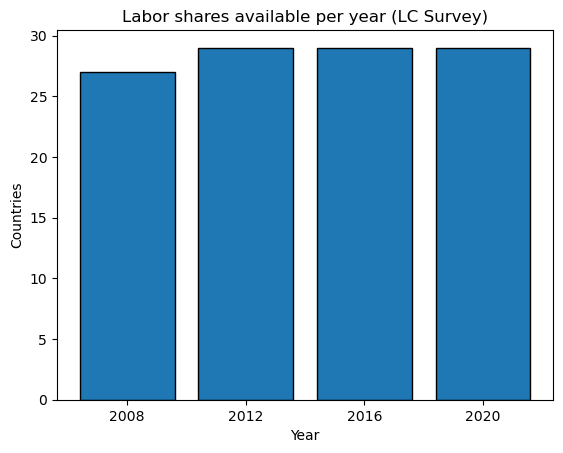

In [1193]:
plt.hist(labour_cost_survey_shares_employment_fte['TIME_PERIOD'], bins=[y - 2 for y in time_periods] + [2022], edgecolor='black', align='mid', rwidth=0.8)
plt.xticks(time_periods); plt.xlabel('Year'); plt.ylabel('Countries'); plt.title('Labor shares available per year (LC Survey)')

Text(0.5, 1.0, 'Labor shares available per year (LC Survey)')

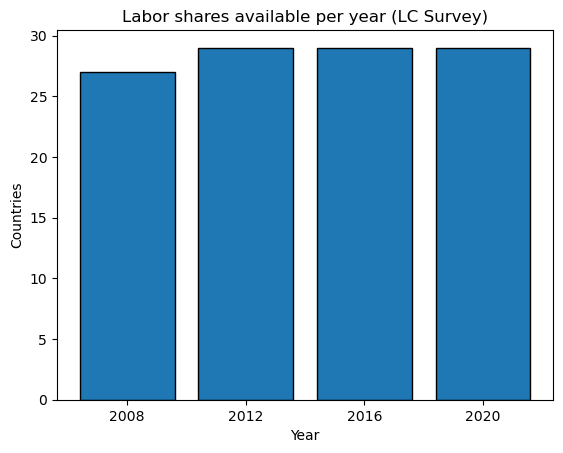

In [1194]:
plt.hist(labour_cost_survey_shares_employment_fte_exiobase['TIME_PERIOD'], bins=[y - 2 for y in time_periods] + [2022], edgecolor='black', align='mid', rwidth=0.8)
plt.xticks(time_periods); plt.xlabel('Year'); plt.ylabel('Countries'); plt.title('Labor shares available per year (LC Survey)')

In [1195]:
energy_use_iea_selected_years = energy_use_iea[energy_use_iea['TIME_PERIOD'].isin(time_periods)]
energy_use_iea_selected = energy_use_iea_selected_years[energy_use_iea_selected_years.geo.isin(labour_cost_survey_shares_employment_fte.geo.unique())]
energy_use_iea_selected_years_accounts = energy_use_iea[energy_use_iea['TIME_PERIOD'].isin(labour_accounts_shares_employment.TIME_PERIOD.unique())]
energy_use_iea_selected_years_accounts[energy_use_iea_selected_years_accounts.geo.isin(labour_accounts_shares_employment.geo.unique())]

,geo,TIME_PERIOD,energy
0,AT,1995,112.158943
1,BE,1995,157.494601
2,BG,1995,58.702334
3,CY,1995,59.549489
4,CZ,1995,111.310297
...,...,...,...
1297,RO,2021,56.531798
1298,SE,2021,132.527085
1299,SI,2021,96.162657
1300,SK,2021,90.254176


Text(0.5, 1.0, 'Energy use data available per year')

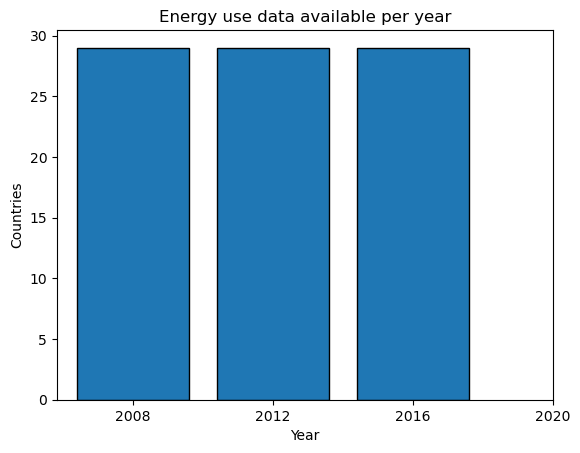

In [1196]:
plt.hist(energy_use_iea_selected['TIME_PERIOD'], bins=[y - 2 for y in time_periods], edgecolor='black', align='mid', rwidth=0.8)
plt.xticks(time_periods); plt.xlabel('Year'); plt.ylabel('Countries'); plt.title('Energy use data available per year')

In [1197]:
energy_use_exiobase_selected_years = energy_use_exiobase[energy_use_exiobase['TIME_PERIOD'].isin(time_periods)]
energy_use_exiobase_selected = energy_use_exiobase_selected_years[energy_use_exiobase_selected_years.geo.isin(labour_cost_survey_shares_employment_fte_exiobase.geo.unique())]
energy_use_exiobase_selected_years_accounts = energy_use_exiobase[energy_use_exiobase['TIME_PERIOD'].isin(labour_accounts_shares_employment_exiobase.TIME_PERIOD.unique())]
energy_use_exiobase_selected_years_accounts[energy_use_exiobase_selected_years_accounts.geo.isin(labour_accounts_shares_employment_exiobase.geo.unique())]

,geo,TIME_PERIOD,energy
0,AT,1995,121.866724
1,BE,1995,76.872893
2,BG,1995,15.493616
3,CY,1995,89.364485
4,CZ,1995,82.147956
...,...,...,...
1297,RO,2021,71.880035
1298,SE,2021,114.088361
1299,SI,2021,95.439943
1300,SK,2021,194.000779


Text(0.5, 1.0, 'Energy use data available per year (Exiobase)')

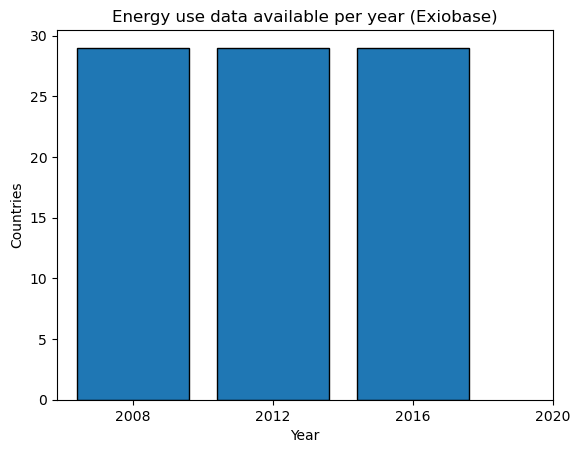

In [1198]:
plt.hist(energy_use_exiobase_selected['TIME_PERIOD'], bins=[y - 2 for y in time_periods], edgecolor='black', align='mid', rwidth=0.8)
plt.xticks(time_periods); plt.xlabel('Year'); plt.ylabel('Countries'); plt.title('Energy use data available per year (Exiobase)')

Assemble energy use, labor and need satisfaction data into a single dataset.

In [1199]:
energy_use_employment = labour_cost_survey_shares_employment_fte.merge(energy_use_iea_selected, on=['geo', 'TIME_PERIOD'], how='left')
energy_use_employment_need_satisfaction = energy_use_employment.merge(need_satisfaction, on=['geo', 'TIME_PERIOD'], how='left')
energy_use_employment_need_satisfaction_provisioning_factors = energy_use_employment_need_satisfaction.merge(wdi_provisioning_factors, on=['geo', 'TIME_PERIOD'], how='left')

In [1200]:
energy_use_employment_accounts = labour_accounts_shares_employment.merge(energy_use_iea_selected_years_accounts, on=['geo', 'TIME_PERIOD'], how='left')
energy_use_employment_need_satisfaction_accounts = energy_use_employment_accounts.merge(need_satisfaction, on=['geo', 'TIME_PERIOD'], how='left')
energy_use_employment_need_satisfaction_provisioning_factors_accounts = energy_use_employment_need_satisfaction_accounts.merge(wdi_provisioning_factors, on=['geo', 'TIME_PERIOD'], how='left')

Same but with exiobase energy data

In [1201]:
energy_use_employment_exiobase = labour_cost_survey_shares_employment_fte_exiobase.merge(energy_use_exiobase_selected, on=['geo', 'TIME_PERIOD'], how='left')
energy_use_employment_need_satisfaction_exiobase = energy_use_employment_exiobase.merge(need_satisfaction, on=['geo', 'TIME_PERIOD'], how='left')
energy_use_employment_need_satisfaction_provisioning_factors_exiobase = energy_use_employment_need_satisfaction_exiobase.merge(wdi_provisioning_factors, on=['geo', 'TIME_PERIOD'], how='left')

In [1202]:
energy_use_employment_accounts_exiobase = labour_accounts_shares_employment_exiobase.merge(energy_use_exiobase_selected_years_accounts, on=['geo', 'TIME_PERIOD'], how='left')
energy_use_employment_need_satisfaction_accounts_exiobase = energy_use_employment_accounts_exiobase.merge(need_satisfaction, on=['geo', 'TIME_PERIOD'], how='left')
energy_use_employment_need_satisfaction_provisioning_factors_accounts_exiobase = energy_use_employment_need_satisfaction_accounts_exiobase.merge(wdi_provisioning_factors, on=['geo', 'TIME_PERIOD'], how='left')

Rename some columns and save the resulting (non-transformed) data as a CSV

In [1203]:
foundational_df_no_transformations = energy_use_employment_need_satisfaction_provisioning_factors.rename(columns={'Material': 'material', 'Other': 'other', 'Overlooked': 'overlooked', 'Providential': 'providential', 'Foundational': 'foundational', 'Nonfoundational': 'nonfoundational'})
foundational_df_no_transformations.to_csv('./output/foundational_no_transformations.csv', index=False) 

In [1204]:
foundational_df_no_transformations_exiobase = energy_use_employment_need_satisfaction_provisioning_factors_exiobase.rename(columns={'Material': 'material', 'Other': 'other', 'Overlooked': 'overlooked', 'Providential': 'providential', 'Foundational': 'foundational', 'Nonfoundational': 'nonfoundational'})
foundational_df_no_transformations_exiobase.to_csv('./output/foundational_df_no_transformations_exiobase.csv', index=False) 

In [1205]:
foundational_df_no_transformations_accounts = energy_use_employment_need_satisfaction_provisioning_factors_accounts.rename(columns={'Material': 'material', 'Other': 'other', 'Overlooked': 'overlooked', 'Providential': 'providential', 'Foundational': 'foundational', 'Nonfoundational': 'nonfoundational'})
foundational_df_no_transformations_accounts.to_csv('./output/foundational_no_transformations_accounts.csv', index=False) 

In [1206]:
foundational_df_no_transformations_accounts_exiobase = energy_use_employment_need_satisfaction_provisioning_factors_accounts_exiobase.rename(columns={'Material': 'material', 'Other': 'other', 'Overlooked': 'overlooked', 'Providential': 'providential', 'Foundational': 'foundational', 'Nonfoundational': 'nonfoundational'})
foundational_df_no_transformations_accounts_exiobase.to_csv('./output/foundational_no_transformations_accounts_exiobase.csv', index=False) 

Final (non-transformed) data frame

In [1207]:
foundational_df_no_transformations

,geo,TIME_PERIOD,material,other,overlooked,providential,foundational,nonfoundational,energy,ladder,...,pop100k,rail,housing,education,dietaryrisks,unsafewater,nutrideficiencies,healthessential,goveffectiveness,gini
0,AT,2008,0.158141,0.505986,0.202933,0.132940,0.291081,0.708919,135.990634,7.181,...,83.07368,130.450463,NaN,15.770060,0.138273,0.000193,0.049106,NaN,1.771053,30.4
1,AT,2012,0.161036,0.517468,0.205395,0.116101,0.277137,0.722863,133.894467,7.401,...,84.07717,134.673895,83.7,16.085060,0.133791,0.000205,0.047559,NaN,1.559877,30.5
2,AT,2016,0.155858,0.522749,0.196575,0.124817,0.280675,0.719325,133.483159,7.048,...,87.00233,144.570841,84.9,16.081190,0.130343,0.000244,0.044531,NaN,1.504636,30.8
3,AT,2020,0.149741,0.530297,0.190191,0.129771,0.279512,0.720488,124.920470,7.213,...,89.01106,83.326780,86.3,16.007959,0.130745,0.000232,NaN,NaN,1.645901,29.8
4,BE,2008,0.155721,0.418183,0.113784,0.312312,0.468033,0.531967,166.054142,7.117,...,106.89752,97.345570,NaN,18.991390,0.115329,0.000740,0.050800,NaN,1.380659,28.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,SK,2016,0.162864,0.460608,0.116955,0.259574,0.422438,0.577562,79.125942,5.993,...,NaN,NaN,92.0,14.531800,0.216352,0.000414,0.086038,NaN,0.826410,25.2
110,SK,2020,0.159124,0.454118,0.113074,0.273684,0.432808,0.567192,83.313266,6.519,...,NaN,NaN,93.3,14.513040,0.221653,0.000388,NaN,NaN,0.537020,NaN
111,TR,2012,0.191779,0.422668,0.275170,0.110383,0.302162,0.697838,48.318921,5.309,...,NaN,NaN,44.5,14.420370,0.085191,0.004514,0.113062,NaN,0.432587,40.2
112,TR,2016,0.150860,0.445809,0.290672,0.112659,0.263519,0.736481,51.008704,5.326,...,NaN,NaN,52.6,17.698681,0.088180,0.003971,0.106308,NaN,0.030258,41.9


With exiobase data

In [1208]:
foundational_df_no_transformations_exiobase.head()

,geo,TIME_PERIOD,material,other,overlooked,providential,foundational,nonfoundational,energy,ladder,...,pop100k,rail,housing,education,dietaryrisks,unsafewater,nutrideficiencies,healthessential,goveffectiveness,gini
0,AT,2008,0.158141,0.505986,0.202933,0.132940,0.291081,0.708919,136.636837,7.181,...,83.07368,130.450463,NaN,15.770060,0.138273,0.000193,0.049106,NaN,1.771053,30.4
1,AT,2012,0.161036,0.517468,0.205395,0.116101,0.277137,0.722863,158.587267,7.401,...,84.07717,134.673895,83.7,16.085060,0.133791,0.000205,0.047559,NaN,1.559877,30.5
2,AT,2016,0.155858,0.522749,0.196575,0.124817,0.280675,0.719325,104.751398,7.048,...,87.00233,144.570841,84.9,16.081190,0.130343,0.000244,0.044531,NaN,1.504636,30.8
3,AT,2020,0.149741,0.530297,0.190191,0.129771,0.279512,0.720488,140.588024,7.213,...,89.01106,83.326780,86.3,16.007959,0.130745,0.000232,NaN,NaN,1.645901,29.8
4,BE,2008,0.155721,0.418183,0.113784,0.312312,0.468033,0.531967,258.711435,7.117,...,106.89752,97.345570,NaN,18.991390,0.115329,0.000740,0.050800,NaN,1.380659,28.4


In [1209]:
foundational_df_no_transformations_accounts.head()

,geo,TIME_PERIOD,material,other,overlooked,providential,foundational,nonfoundational,energy,ladder,...,pop100k,rail,housing,education,dietaryrisks,unsafewater,nutrideficiencies,healthessential,goveffectiveness,gini
0,AT,1995,0.196865,0.584168,0.108970,0.109996,0.306861,0.693139,112.158943,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AT,1996,0.197065,0.582858,0.105658,0.114420,0.311485,0.688515,121.759504,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.731650,29.3
2,AT,1997,0.196480,0.584765,0.105132,0.113623,0.310103,0.689897,120.125771,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AT,1998,0.197430,0.586049,0.105004,0.111517,0.308947,0.691053,122.165832,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.803506,31.3
4,AT,1999,0.200706,0.586324,0.103236,0.109734,0.310440,0.689560,123.119330,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Next step: exploratory analysis! See [exploratory.ipynb](exploratory.ipynb)